In [1]:
import math, glob, time, os, re, json
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

In [2]:
def normalized_histogram(data, bins):
    weights = np.ones_like(data) / len(data)
    return np.histogram(data, bins, weights = weights)

plt.rcParams.update({'font.size': 22})

In [3]:
moves_data = pd.read_csv('moves-20b.csv.gz',index_col=0)
games_data = pd.read_csv('games-20b.csv.gz',index_col=0)
print(f"Loaded {games_data.shape[0]} games and {moves_data.shape[0]} moves.")

Loaded 2431 games and 665119 moves.


In [4]:
user_moves = moves_data[moves_data.move_color==moves_data.user_color].copy()

In [13]:
segment_length = 60
half_seg = 30
def make_features(df,segment_mid):
    df = df[(df.move >= segment_mid - half_seg+1) & (df.move <= segment_mid+half_seg)]
    if df.shape[0] != half_seg:
        return None
    pol_rank_frac, _bins = normalized_histogram(df.policy_rank.values,
                                                bins=[-0.5,0.5,3.5,9.5,19.5,39.5,79.5])
    score_loss, _bins = normalized_histogram(df.points_lost.clip(-6,50),bins=[-6,-1.5,-0.5,0.5,1.5,3,6,12,25,50])
    df.num_legal
    
    # mean/ median legal moves?
    f =  {f"{k}.{i}":v for k,l in {'policy_rank_hist':pol_rank_frac,
                                  'score_loss_hist':score_loss}.items()
                       for i,v in enumerate(l) } 
    f['n_legal'] = df.num_legal.mean()
    return f

In [14]:
moves_data

,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color
0,24614579,1,362,37,0.000729,0.083457,-1.340746,0.628943,black,white
1,24614579,2,361,6,0.018248,0.416445,-1.148735,0.192010,white,white
2,24614579,3,360,21,0.000658,0.574577,-1.575831,0.427096,black,white
3,24614579,4,359,5,0.016626,0.451228,-1.588290,-0.012458,white,white
4,24614579,5,358,15,0.000753,0.564865,-1.899404,0.311114,black,white
...,...,...,...,...,...,...,...,...,...,...
665114,24679322,264,107,4,0.046985,0.078753,-50.762959,-1.000729,white,black
665115,24679322,265,114,0,0.070761,0.070761,-49.834446,-0.928513,black,black
665116,24679322,266,106,0,0.080871,0.080871,-50.532585,-0.698139,white,black
665117,24679322,267,113,0,0.079108,0.079108,-49.847683,-0.684902,black,black


In [17]:
x = []
y = []
x_game_id = []
for game_id,df in tqdm(user_moves.groupby('game_id')):
    for segment_mid in range(30,max(df.move)-30,30):
        features = make_features(df,segment_mid)
        if features is not None:
            x_game_id.append(game_id)
            x.append(features)
            y.append( games_data.loc[game_id,'user_rank'] )

In [21]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

df = pd.DataFrame(x)
y_all=np.array(y)
sel = y_all<15
y_sel = y_all[sel]
x=df.values
xN_sel = ss.fit_transform(x[sel,:])
xN_all = ss.transform(x)
x_game_id=np.array(x_game_id)
xN_sel

array([[ 0.65900093,  2.06687613, -2.0942261 , ..., -0.47502476,
        -0.26637627,  1.43243315],
       [ 1.1520722 , -0.43502168, -1.63885353, ..., -0.47502476,
        -0.26637627,  0.97741435],
       [ 0.90553657, -0.43502168, -0.72810839, ..., -0.47502476,
        -0.26637627,  0.53099035],
       ...,
       [ 0.16592966,  0.63722024, -0.27273582, ..., -0.47502476,
        -0.26637627, -0.72890615],
       [-0.08060597,  0.27980627, -0.27273582, ..., -0.47502476,
        -0.26637627, -1.16167958],
       [ 0.4124653 ,  0.27980627,  1.09338189, ..., -0.47502476,
        -0.26637627, -1.54086192]])

In [31]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
model = Sequential()
model.add(Dense(20, input_dim=16, activation='tanh')) #, kernel_regularizer='l2'))
model.add(Dense(10, activation='tanh')) # , kernel_regularizer='l2'))
model.add(Dense(1, activation=None))
model.compile(loss='mse', optimizer='adam')

In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(xN_sel, y_sel, epochs=100, batch_size=16,verbose=0,
                    validation_split=0.1,callbacks=[TQDMNotebookCallback(),es]) 


Epoch 00017: early stopping


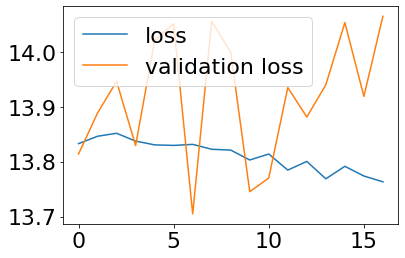

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']); plt.legend(['loss','validation loss'])

Text(0, 0.5, 'Predicted Rank')

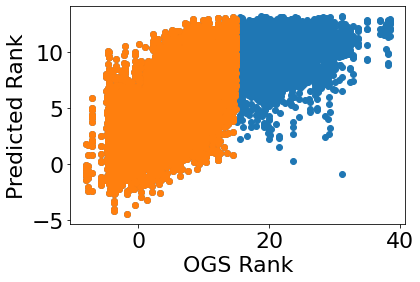

In [36]:
pY = model.predict(xN_all)[:,0]
pY_sel = model.predict(xN_sel)[:,0]
plt.scatter(y,pY)
plt.scatter(y_sel,pY_sel)
plt.xlabel('OGS Rank')
plt.ylabel('Predicted Rank')

Text(0, 0.5, 'Predicted Rank')

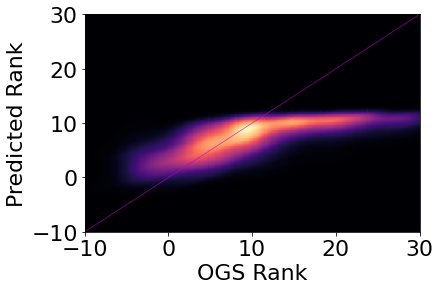

In [26]:
from scipy.stats import kde
nbins=300
k = kde.gaussian_kde(np.array([y,pY]))
xi, yi = np.mgrid[-10:30:nbins*1j, -10:30:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.magma)
plt.plot([-10, 30], [-10, 30], linewidth=0.5, c='m')
plt.xlabel('OGS Rank')
plt.ylabel('Predicted Rank')